### Описание проекта

К нам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров.  

Фермер желает очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. 

Поэтому он просит нас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке.

С помощью модели нужно отобрать коров по двум критериям:  
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

In [1]:
! pip install phik -q # -q убирает необязательные выводы в командах Linux

In [2]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression 

from sklearn.model_selection import train_test_split

from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.multiclass import OneVsRestClassifier

try:
    import phik
except:
    !pip install phik
    import phik
from phik.report import plot_correlation_matrix

from scipy import stats
RANDOM_STATE = 42

## Загрузка данных

In [3]:
try:
    ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
except:
    ferma_main = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', sep=';', decimal=',')

In [4]:
try:
    ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal=',')
except:
    ferma_dad = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', sep=';', decimal=',')

In [5]:
try:
    cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')
except:
    cow_buy = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', sep=';', decimal=',')

In [6]:
display(ferma_main.head(5))

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [7]:
display(ferma_dad.head(5))

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [8]:
display(cow_buy.head(5))

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


##  Предобработка данных

In [9]:
ferma_main.info()
print('----')
ferma_dad.info()
print('----')
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

Проверим количество пропусков

In [10]:
ferma_main.isna().sum()

id                                       0
Удой, кг                                 0
ЭКЕ (Энергетическая кормовая единица)    0
Сырой протеин, г                         0
СПО (Сахаро-протеиновое соотношение)     0
Порода                                   0
Тип пастбища                             0
порода папы_быка                         0
Жирность,%                               0
Белок,%                                  0
Вкус молока                              0
Возраст                                  0
dtype: int64

In [11]:
ferma_dad.isna().sum()

id          0
Имя Папы    0
dtype: int64

In [12]:
cow_buy.isna().sum()

Порода                     0
Тип пастбища               0
порода папы_быка           0
Имя_папы                   0
Текущая_жирность,%         0
Текущий_уровень_белок,%    0
Возраст                    0
dtype: int64

In [13]:
# В целях оптимизации сделаем один словарь для переименования всех возможных колонок
possible_columns = {'Удой, кг': 'milk_kg',
                    'ЭКЕ (Энергетическая кормовая единица)': 'eke',
                    'Сырой протеин, г': 'protein_g',
                    'СПО (Сахаро-протеиновое соотношение)': 'spo',
                    'Порода': 'cow_breed',
                    'Тип пастбища': 'pasture_type',
                    'порода папы_быка': 'dad_breed',
                    'Жирность,%': 'fat_share',
                    'Текущая_жирность,%': 'fat_share', 
                    'Белок,%': 'protein_share',
                    'Текущий_уровень_белок,%': 'protein_share',
                    'Вкус молока': 'taste', 
                    'Возраст': 'age',
                    'Имя Папы': 'dad_name',
                    'Имя_папы': 'dad_name'
                     }

ferma_main.rename(columns=possible_columns, inplace=True)
ferma_dad.rename(columns=possible_columns, inplace=True)
cow_buy.rename(columns=possible_columns, inplace=True)

In [14]:
#display(ferma_main.head())
#display(ferma_dad.head())
#display(cow_buy.head())

In [15]:
# В ferma_main тип пастбища написан с заглавной буквы а в cow_buy с маленькой, приведем к одному виду.
ferma_main['pasture_type'] = ferma_main['pasture_type'].str.lower()

In [16]:
#создадим функцию которая ищет дубликаты и удаляет их.
def drop_duplicates(df):
    '''Показывает количество дубликатов и при необходимости удаляет'''
    duplicated = df.duplicated().sum()
    print(f'Найдено {duplicated} дублей')
    if duplicated > 0:
        df = df.drop_duplicates()
        duplicated = df.duplicated().sum()
        print(f'После удаления осталось {duplicated} дублей')
    return df

In [17]:
#Проверим наличие дубликатов и удалим при необходимости
ferma_main = drop_duplicates(ferma_main).reset_index().drop(['index'], axis=1)

Найдено 5 дублей
После удаления осталось 0 дублей


In [18]:
ferma_dad = drop_duplicates(ferma_dad).reset_index().drop(['index'], axis=1)

Найдено 0 дублей


In [19]:
cow_buy = drop_duplicates(cow_buy).reset_index().drop(['index'], axis=1)

Найдено 4 дублей
После удаления осталось 0 дублей


##### Промежуточный вывод (предобработка данных)

- загрузили данные
- проверили размерность датасетов
- удалили явные дубликаты 
- изменили названия всех столбцов
- привели данные в столбцах к единообразному виду 

Теперь у нас корректные данные для дальнейшей работы.

## Исследовательский анализ данных

##### Категориальные признаки - main_ferma 

Построим графики для каждого признака

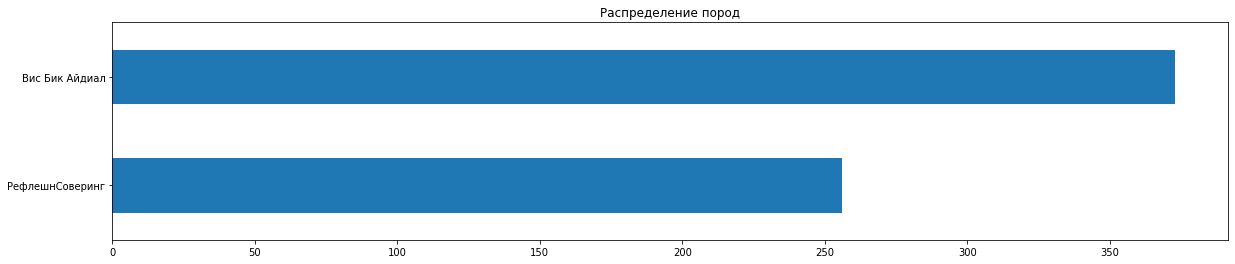

In [20]:
ferma_main['cow_breed'].value_counts().sort_values().plot.barh(figsize=(20, 4))
plt.title('Распределение пород')
plt.show()

Неравномерно представлено всего две породы

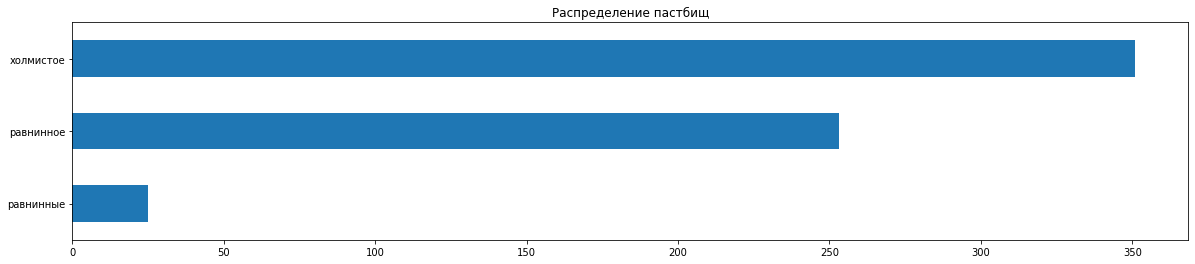

In [21]:
ferma_main['pasture_type'].value_counts().sort_values().plot.barh(figsize=(20, 4))
plt.title('Распределение пастбищ')
plt.show()

Чаще всего коров пасут на холмистой местности.  
Также видно неявный дубль равнинной местности, его стоит перезаписать.

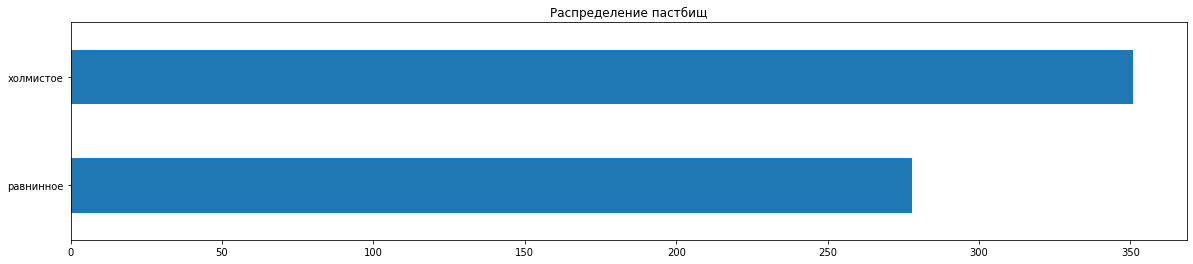

In [22]:
# Преобразуем неявный дубликат.
ferma_main = ferma_main.replace('равнинные', 'равнинное')
ferma_main['pasture_type'].value_counts().sort_values().plot.barh(figsize=(20, 4))
plt.title('Распределение пастбищ')
plt.show()

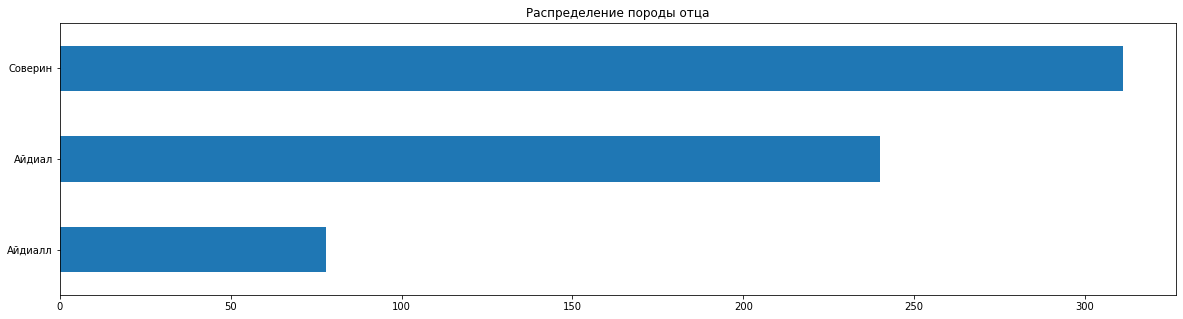

In [23]:
ferma_main['dad_breed'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение породы отца')
plt.show()

Еще один неявный дубликат Айдиал, исправим его.

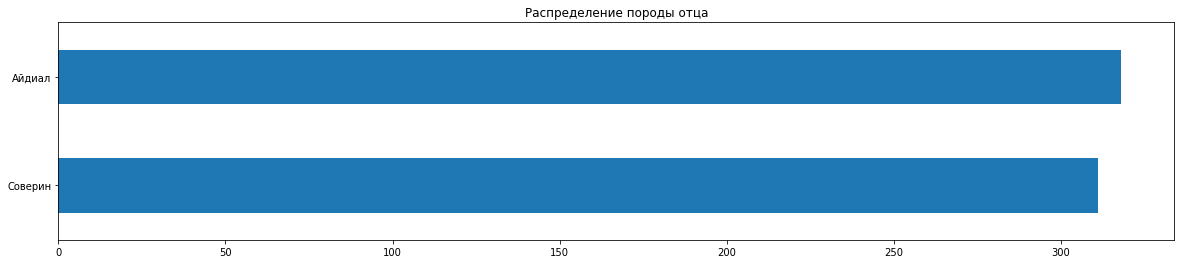

In [24]:
ferma_main = ferma_main.replace('Айдиалл', 'Айдиал')
ferma_main['dad_breed'].value_counts().sort_values().plot.barh(figsize=(20, 4))
plt.title('Распределение породы отца')
plt.show()

После преобразования неявного дубликата, Айдиал стало намного больше.

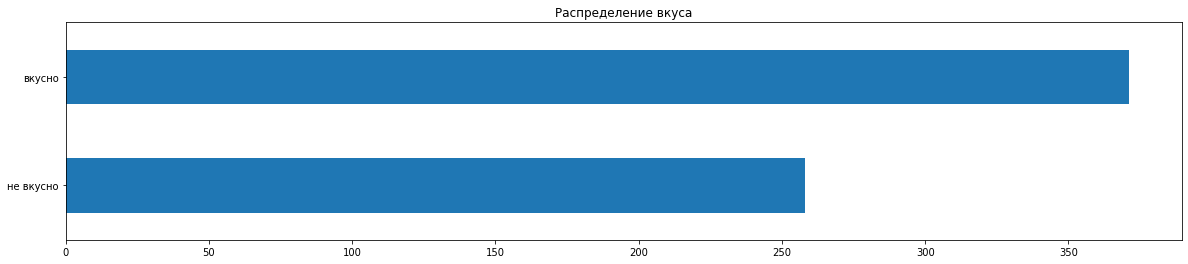

In [25]:
ferma_main['taste'].value_counts().sort_values().plot.barh(figsize=(20, 4))
plt.title('Распределение вкуса')
plt.show()

Как мы видим, вкусное молоко встречается чаще.

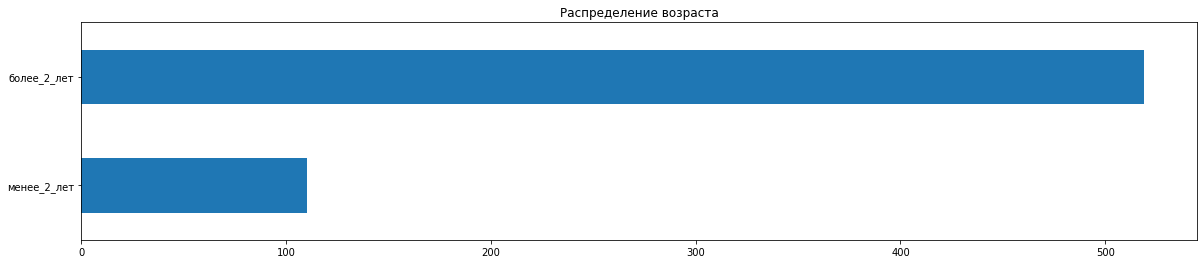

In [26]:
ferma_main['age'].value_counts().sort_values().plot.barh(figsize=(20, 4))
plt.title('Распределение возраста')
plt.show()

Коров старше двух лет намного больше.

##### Количественные признаки - main_ferma 

Для оптимизации работы создадим функцию которая построит графики для количественных переменных.

In [27]:
def plot_numeric(df, variable, title, xlabel, bins):
    '''Рисует графики распределения количественных переменных'''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    f.suptitle(title, fontsize=20)
    ax1.boxplot(df[variable])
    ax1.set_title('Ящик с усами')
    ax1.set_xlabel(xlabel)
    ax1.set_xticks([])
    
    ax2.hist(df[variable], bins=bins)
    ax2.set_title('Гистограмма')
    ax2.set_xlabel(xlabel)
    
    plt.show()

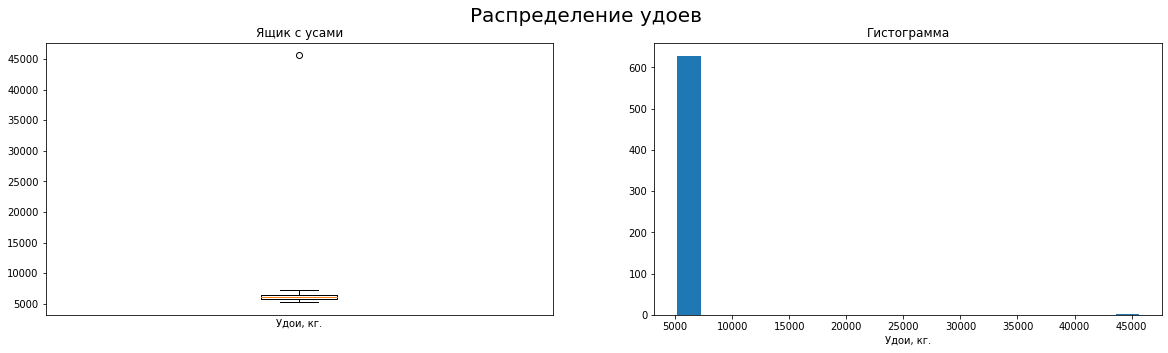

In [28]:
plot_numeric(ferma_main, 'milk_kg', 'Распределение удоев', 'Удои, кг.', 20)

Очень большие выборсы. Выглядит будто они указан в граммах, а не килограммах. Удалим их, так как не знаем наверняка.

In [29]:
ferma_main = ferma_main[ferma_main['milk_kg'] <= 15000]

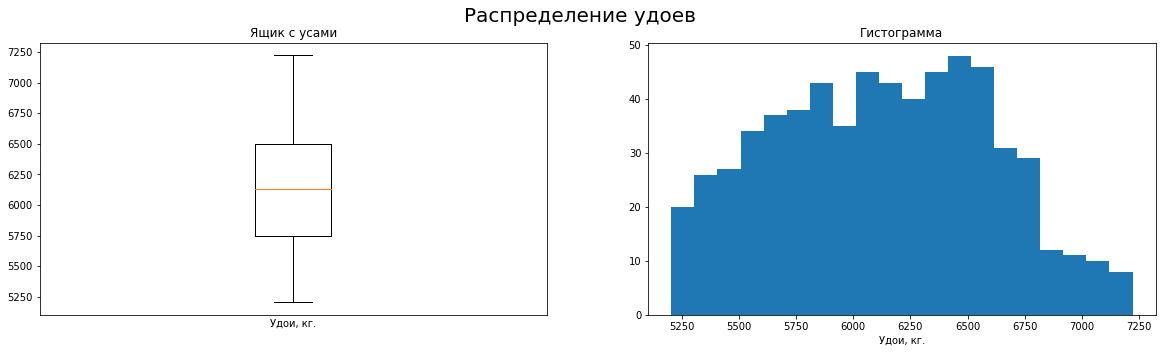

In [30]:
# Вновь посмотрим на наши данные.
plot_numeric(ferma_main, 'milk_kg', 'Распределение удоев', 'Удои, кг.', 20)

In [31]:
stats.shapiro(ferma_main['milk_kg'])

ShapiroResult(statistic=0.981349527835846, pvalue=3.540204147611803e-07)

Поскольку p-значение не меньше 0,05, у нас нет достаточных доказательств, чтобы сказать, что данные выборки не получены из нормального распределения.

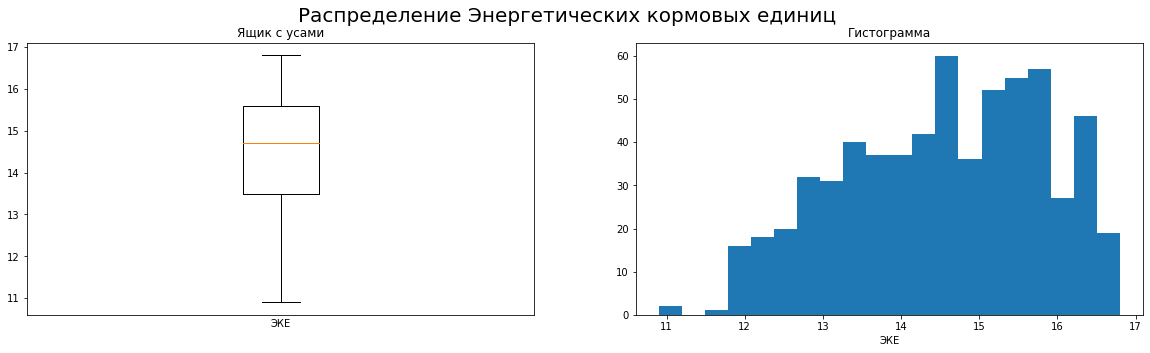

In [32]:
plot_numeric(ferma_main, 'eke', 'Распределение Энергетических кормовых единиц', 'ЭКЕ', 20)

In [33]:
stats.shapiro(ferma_main['eke'])

ShapiroResult(statistic=0.9713221788406372, pvalue=9.631184738623233e-10)

Поскольку p-значение не меньше 0,05, у нас нет достаточных доказательств, чтобы сказать, что данные выборки не получены из нормального распределения.

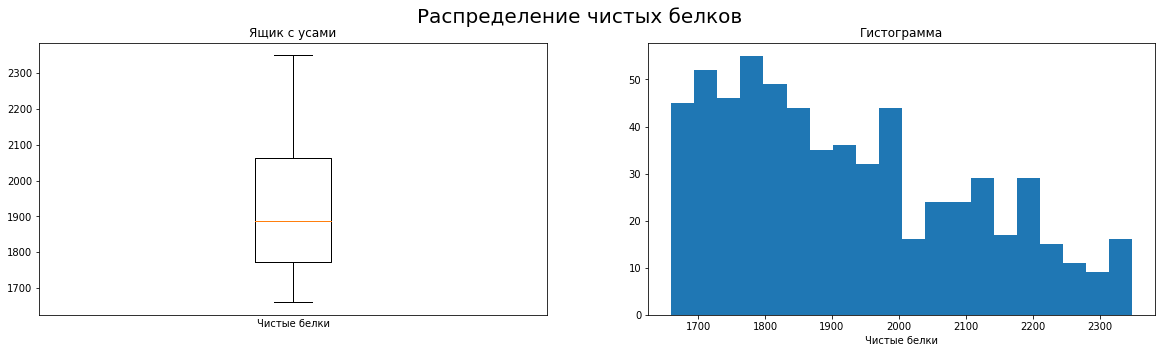

In [34]:
plot_numeric(ferma_main, 'protein_g', 'Распределение чистых белков', 'Чистые белки', 20)

In [35]:
stats.shapiro(ferma_main['protein_g'])

ShapiroResult(statistic=0.9437040686607361, pvalue=1.0713665740159917e-14)

Поскольку p-значение не меньше 0,05, у нас нет достаточных доказательств, чтобы сказать, что данные выборки не получены из нормального распределения.

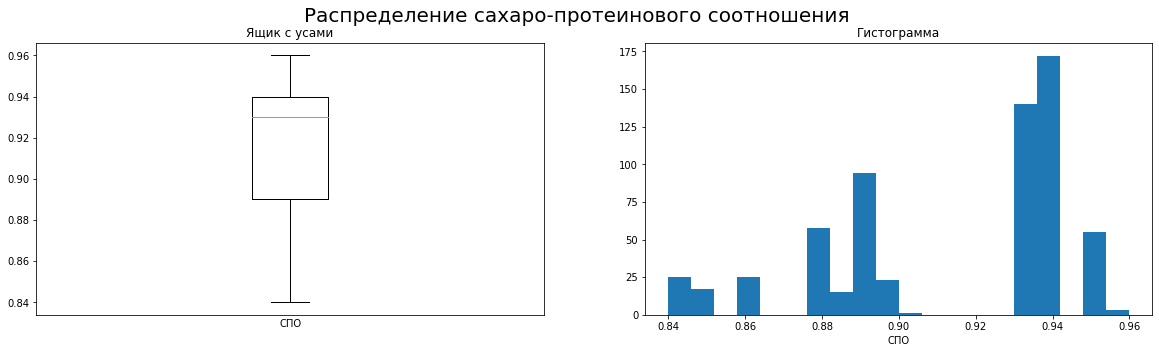

In [36]:
plot_numeric(ferma_main, 'spo', 'Распределение сахаро-протеинового соотношения', 'СПО', 20)

In [37]:
stats.shapiro(ferma_main['spo'])

ShapiroResult(statistic=0.8555195331573486, pvalue=1.5345069056487493e-23)

Поскольку p-значение не меньше 0,05, у нас нет достаточных доказательств, чтобы сказать, что данные выборки не получены из нормального распределения.

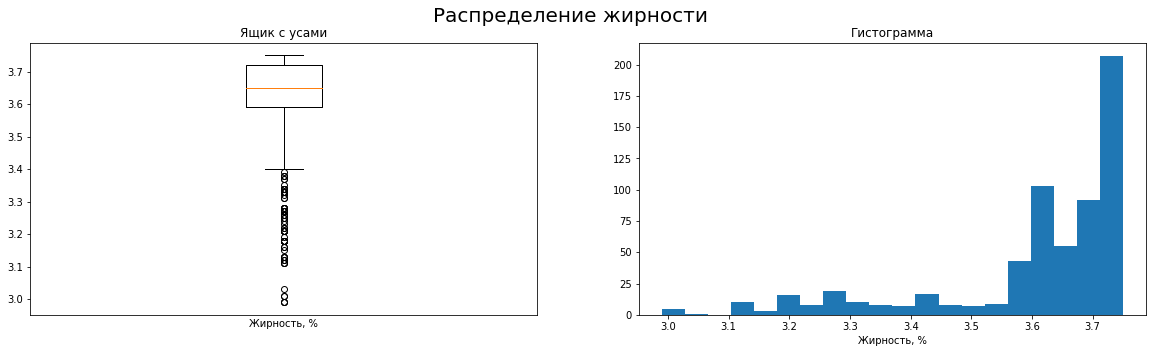

In [38]:
plot_numeric(ferma_main, 'fat_share', 'Распределение жирности', 'Жирность, %', 20)

Ящик с усами показывает нам обилие выбросов, но мы знаем, что молоко 3% жирности это нормально.

In [39]:
stats.shapiro(ferma_main['fat_share'])

ShapiroResult(statistic=0.7418986558914185, pvalue=4.189230905200583e-30)

Поскольку p-значение не меньше 0,05, у нас нет достаточных доказательств, чтобы сказать, что данные выборки не получены из нормального распределения.

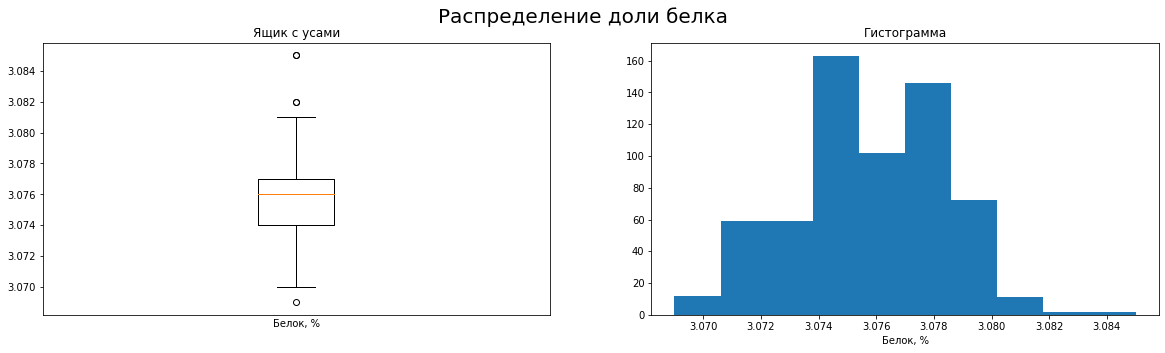

In [40]:
plot_numeric(ferma_main, 'protein_share', 'Распределение доли белка', 'Белок, %', 10)

Между 3.07 и 3.082 не настолько существенна разница, чтобы удалять эти данные как выбросы.

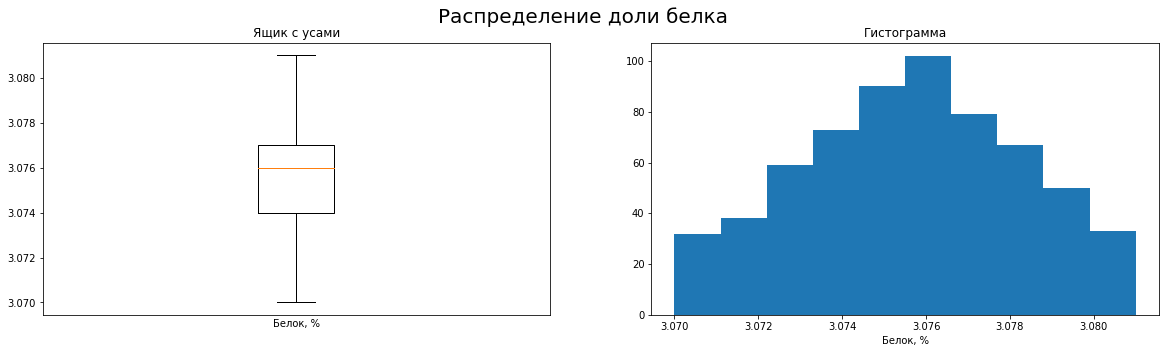

In [41]:
# Установим границы с этими значениями.
ferma_main = ferma_main[(ferma_main['protein_share'] >= 3.07) & (ferma_main['protein_share'] <= 3.081)]
plot_numeric(ferma_main, 'protein_share', 'Распределение доли белка', 'Белок, %', 10)

In [42]:
stats.shapiro(ferma_main['protein_share'])

ShapiroResult(statistic=0.9789979457855225, pvalue=8.562941644640887e-08)

Поскольку p-значение не меньше 0,05, у нас нет достаточных доказательств, чтобы сказать, что данные выборки не получены из нормального распределения.

##### Категориальные признаки - ferma_dad

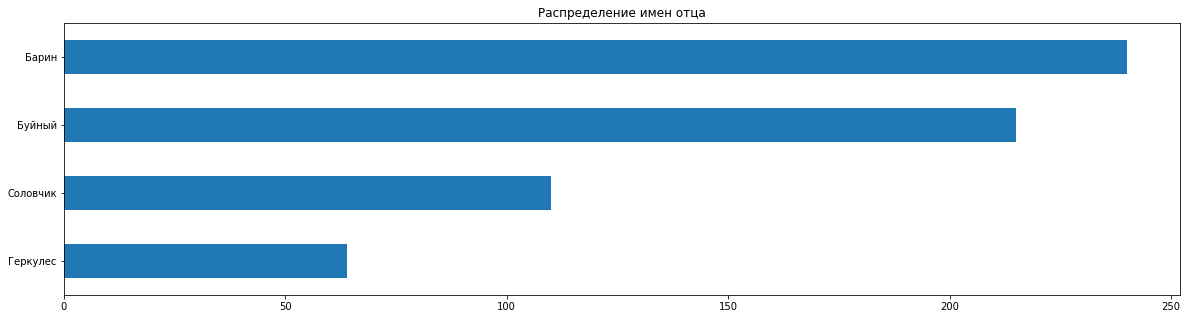

In [43]:
ferma_dad['dad_name'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение имен отца')
plt.show()

Наиболее популярное имя - Барин.

##### Категориальные признаки - cow_buy

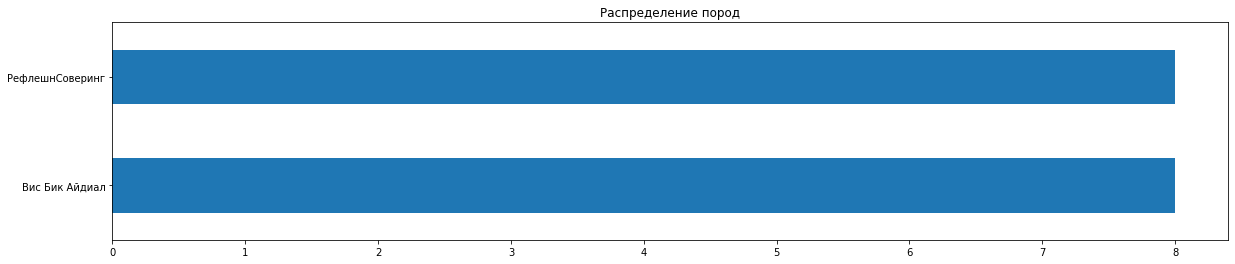

In [44]:
cow_buy['cow_breed'].value_counts().sort_values().plot.barh(figsize=(20, 4))
plt.title('Распределение пород')
plt.show()

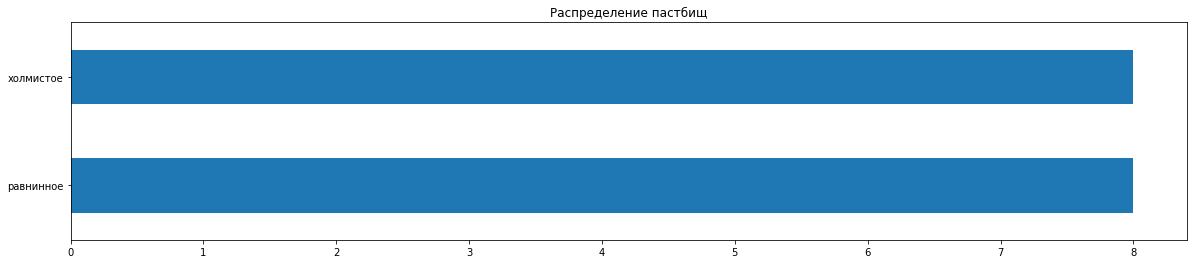

In [45]:
cow_buy['pasture_type'].value_counts().sort_values().plot.barh(figsize=(20, 4))
plt.title('Распределение пастбищ')
plt.show()

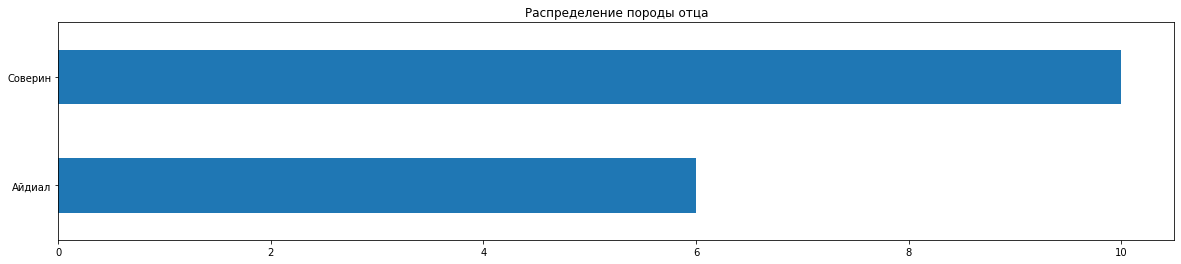

In [46]:
cow_buy['dad_breed'].value_counts().sort_values().plot.barh(figsize=(20, 4))
plt.title('Распределение породы отца')
plt.show()

Порода Соверин встречается чаще.

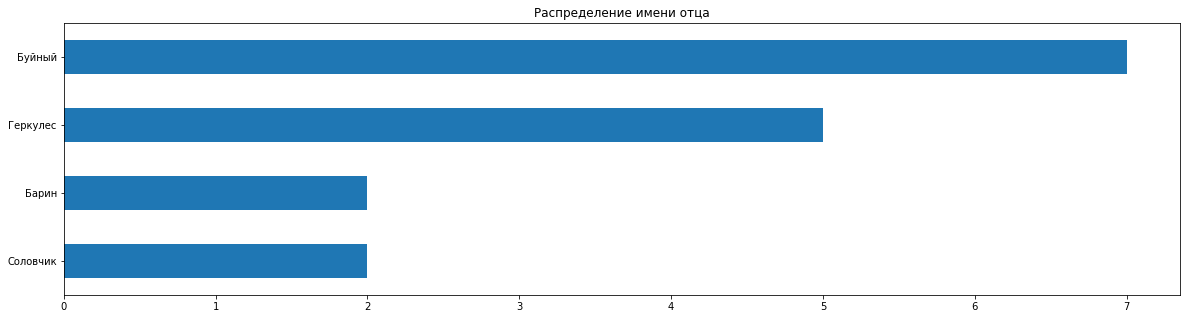

In [47]:
cow_buy['dad_name'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение имени отца')
plt.show()

Самое популярное имя- Буйный.

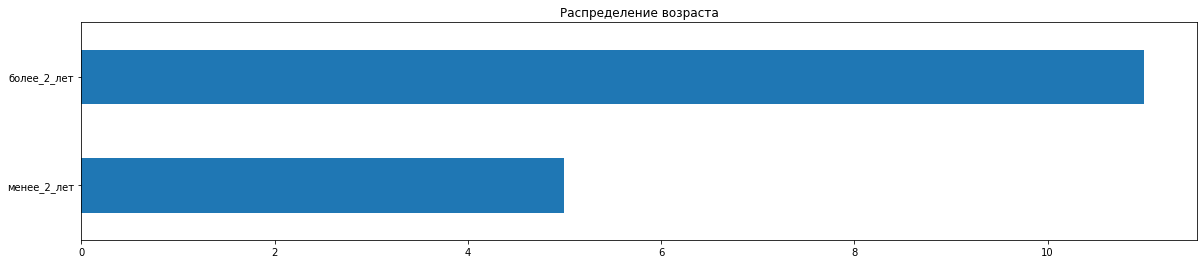

In [48]:
cow_buy['age'].value_counts().sort_values().plot.barh(figsize=(20, 4))
plt.title('Распределение возраста')
plt.show()

Коров старше 2х лет в два раза больше.

##### Количественные признаки - cow_buy

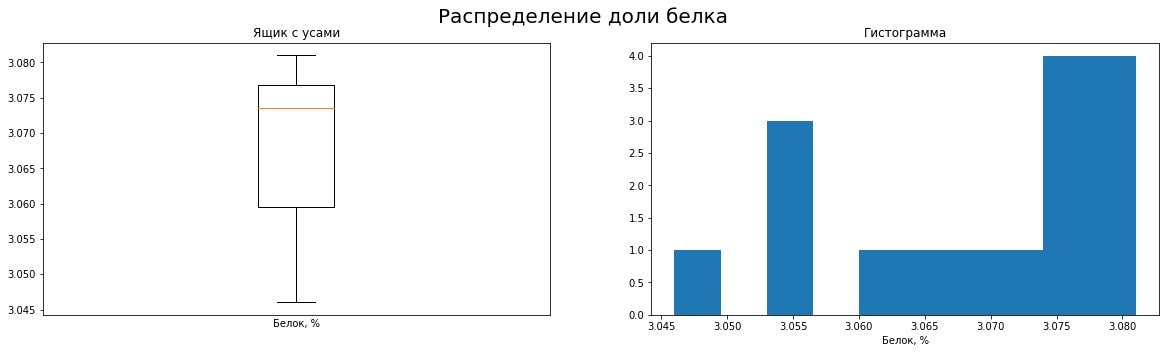

In [49]:
plot_numeric(cow_buy, 'protein_share', 'Распределение доли белка', 'Белок, %', 10)

In [50]:
stats.shapiro(cow_buy['protein_share'])

ShapiroResult(statistic=0.8810991644859314, pvalue=0.04036641865968704)

Поскольку p-значение меньше 0,05, у нас есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения.

##### Промежуточный вывод (исследовательский анализ данных)

- визуализация данных показала наличие неявных дубликатов, от которых мы избавились.
- боксплот показал наличие выбросов и некоректных данных(предположительно в виде граммов в "milk_kg"), от которых мы избавились.
- количественные переменные в основном распределены нормально.

## Корреляционный анализ

In [51]:
# Корреляция между переменными, распределёнными нормально
#ferma_main[['milk_kg', 'protein_share']].corr('pearson')

In [52]:
phik_overview = ferma_main.drop(['id'], axis=1).phik_matrix()

interval columns not set, guessing: ['milk_kg', 'eke', 'protein_g', 'spo', 'fat_share', 'protein_share']


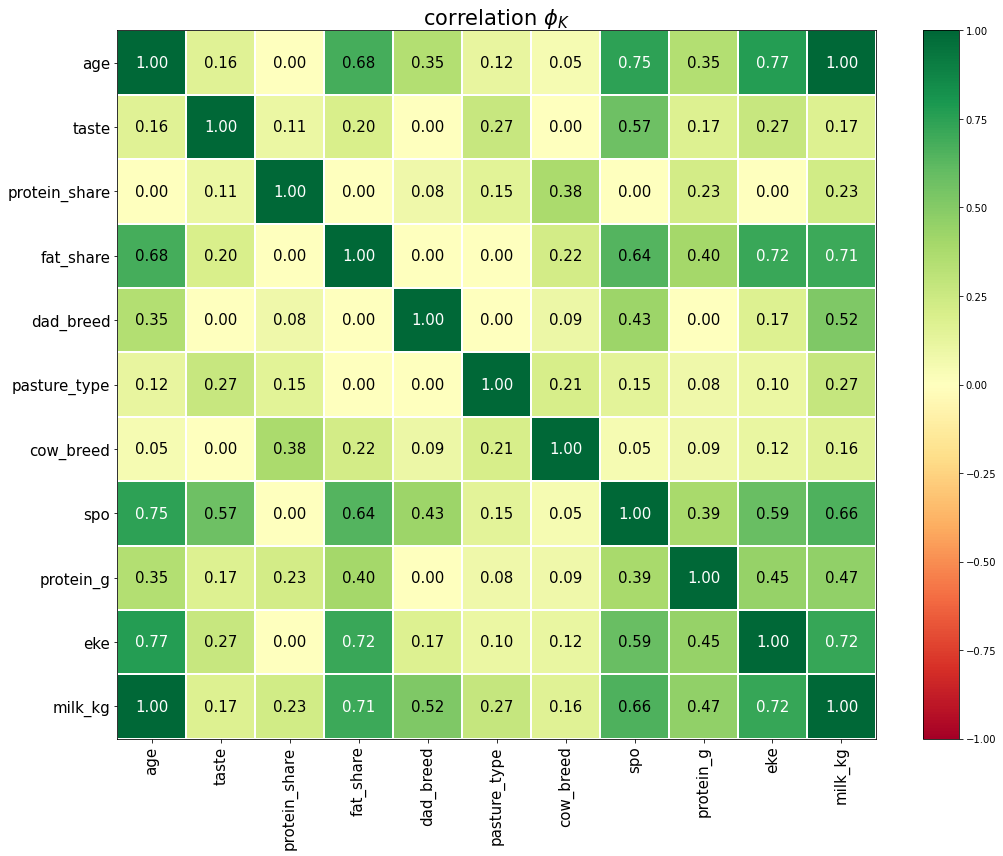

In [53]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12),
)

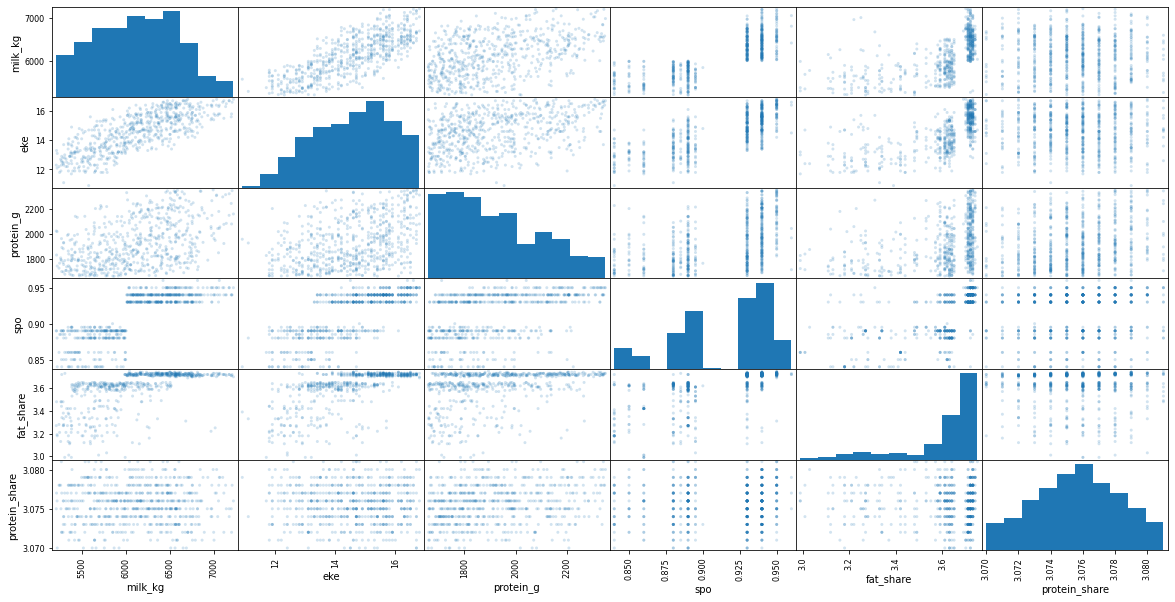

In [54]:
# Построим диагараммы рассеяния.
pd.plotting.scatter_matrix(ferma_main.drop(['id'], axis=1), 
                           alpha=0.2, figsize=(20,10))
plt.show()

Исследуем как признаки влияют на целевой признак удой(milk_kg).

In [55]:
ferma_main.drop('id',  axis=1).phik_matrix()['milk_kg'].sort_values(ascending = False)

interval columns not set, guessing: ['milk_kg', 'eke', 'protein_g', 'spo', 'fat_share', 'protein_share']


milk_kg          1.000000
age              0.998067
eke              0.720303
fat_share        0.707631
spo              0.661352
dad_breed        0.518814
protein_g        0.466145
pasture_type     0.274778
protein_share    0.233484
taste            0.173285
cow_breed        0.162958
Name: milk_kg, dtype: float64

Можно заметить, что dad_breed, spo, fat_share, eke, age более чем заметно коррелируют с нашим целевым признаком согласно шкале Чеддока.

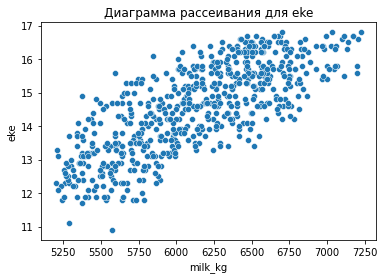

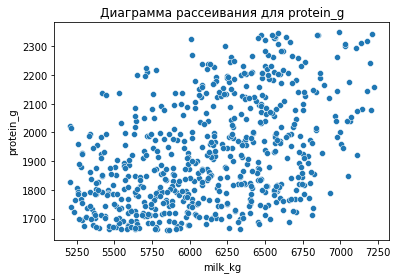

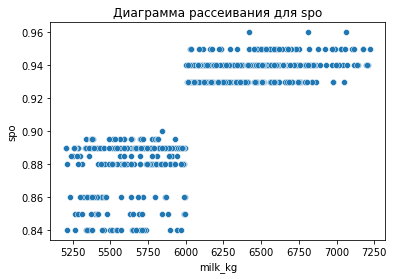

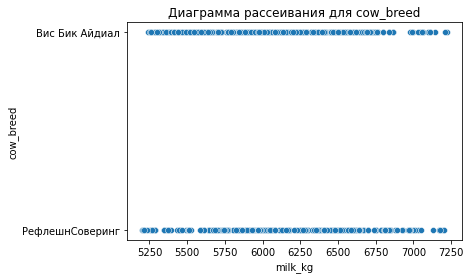

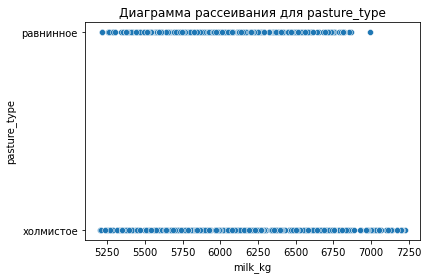

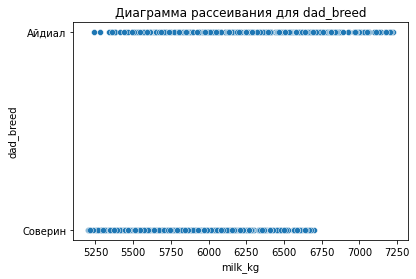

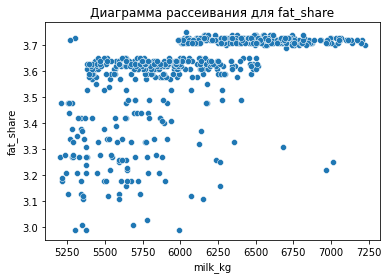

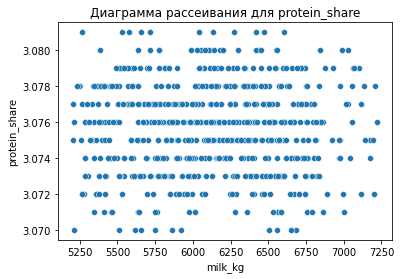

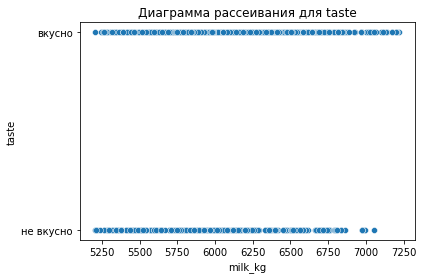

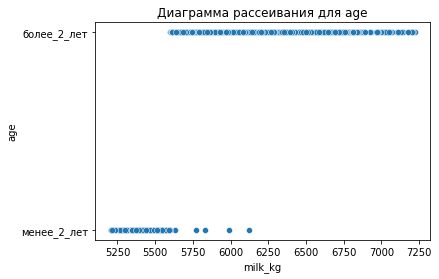

In [56]:
cols = ferma_main.drop(['id', 'milk_kg'], axis=1).columns

for i in cols:
    sns.scatterplot(x = 'milk_kg', y = i, data = ferma_main)
    plt.title(f'Диаграмма рассеивания для {i}')
    plt.show()

eke очень напоминает линейную зависимость, так же можно сказать про показатель protein_g, коэффицент корреляции меньше, но линейная зависимость также наблюдается. Для spo мы наблюдаем график не похожий на предыдущие, но также напоминает линейную зависимость.  
В диаграмме fat_share мы наблюдаем линейную зависимость похожую как с spo, но выбросы показывают, что никак не коррелируют целевым признаком, при обучении модели нужно будет отбросить эти значения, возможно они ухудшат показатели модели.  
protein_share почти никак не коррелирует с целевым признаком.  
По диаграммам категориальных признаков можно сказать, как распределены те или иные признаки относительно значений milk_kg, а именно:  

- Так как cow_bread распределены почти одинаково, то очевидно, что коэффицент корреляции будет мал (0,16).  
- pasture_type показывает, что максимальное значение удоя наблюдается именно на холимостом пастбище, но коэффицент все же мал.  
- Коэффицент корреляции от dad_breed заметный (0,51), по диаграмме заметно, что быки с папами-Айдиалами могут приносить больше удоя.  
- По диаграмме видно, что taste имеет слабую корреляцию с целевым признаком, скорее всего это связано с тем, что 41% не вкусного молока все же внушительное значение, потому и встречается оно довольно часто
- В свою очередь age сильно коррелирует с показателем удоя, коровы с возрастом более двух лет почти гарантированно будут приносить больше удоя чем молодые коровы

In [57]:
# Корреляция между переменными, распределёнными ненормально
ferma_main.drop(['protein_share', 'id'], axis=1).corr('spearman')

,milk_kg,eke,protein_g,spo,fat_share
milk_kg,1.000000,0.764683,0.437322,0.786345,0.687403
eke,0.764683,1.000000,0.383890,0.741703,0.686893
protein_g,0.437322,0.383890,1.000000,0.488510,0.395221
spo,0.786345,0.741703,0.488510,1.000000,0.699486
fat_share,0.687403,0.686893,0.395221,0.699486,1.000000


Больше всего с целевой переменной коррелируют характеристики корма: ЭКЕ, количество граммов чистого протеина и СПО.

#### Подготовка данных

Избавимся от переменных, которые не могут повлиять на удой. В первую очередь характеристики молока. Характеристики корма, порода отца и тип пастбища уже могут повлиять на удой. Их оставим и закодируем.

In [58]:
ferma_main_learning = ferma_main.copy()

Закодируем категориальные признаки с помощью OneHotEncoder.

In [59]:
X = ferma_main_learning.reset_index().drop(['milk_kg', 'index', 'id', 'taste', 
                                          'protein_share', 'fat_share'], axis=1)
y = ferma_main_learning.reset_index().drop(['index'], axis=1)['milk_kg']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=RANDOM_STATE) 

print(f'''X_train nrows: {X_train.shape[0]} ({round(X_train.shape[0] / X.shape[0] * 100)}%)
X_test nrows:  {X_test.shape[0]} ({round(X_test.shape[0] / X.shape[0] * 100)}%)''')

X_train nrows: 467 (75%)
X_test nrows:  156 (25%)


In [60]:
enc = OneHotEncoder(drop='first')

In [61]:
cat_X_train = enc.fit_transform(X_train[['cow_breed', 
                                         'dad_breed', 
                                         'pasture_type', 
                                         'age']]).toarray()

cat_X_test = enc.transform(X_test[['cow_breed', 
                                   'dad_breed', 
                                   'pasture_type', 
                                   'age']]).toarray()
# делаем преобразование и смотрим на получившиеся названия столбцов,  
# чтобы правильно переименовать
enc.get_feature_names()

array(['x0_РефлешнСоверинг', 'x1_Соверин', 'x2_холмистое',
       'x3_менее_2_лет'], dtype=object)

In [62]:
cat_X_train_df = pd.DataFrame(cat_X_train, columns=['is_sovering_breed', 
                                                    'is_sovering_dad',
                                                    'is_hill_pasture',
                                                    'is_younger_2_years'])

cat_X_test_df = pd.DataFrame(cat_X_test, columns=['is_sovering_breed', 
                                                  'is_sovering_dad',
                                                  'is_hill_pasture',
                                                  'is_younger_2_years'])
display(cat_X_train_df.head())
cat_X_train_df.shape

,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years
0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


(467, 4)

In [63]:
# Соединяем закодированные колонки с общим датасетом
X_train = X_train.reset_index().drop(['index'], axis=1)
X_train_for_learning = X_train.merge(cat_X_train_df, 
                                     left_index=True, 
                                     right_index=True)


X_test = X_test.reset_index().drop(['index'], axis=1)
X_test_for_learning = X_test.merge(cat_X_test_df, 
                                     left_index=True, 
                                     right_index=True)
display(X_train_for_learning.head())
X_train_for_learning.shape

,eke,protein_g,spo,cow_breed,pasture_type,dad_breed,age,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years
0,16.6,1966,0.96,Вис Бик Айдиал,равнинное,Соверин,более_2_лет,0.0,1.0,0.0,0.0
1,16.4,1894,0.94,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,0.0,0.0,0.0,0.0
2,14.1,1977,0.89,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,0.0,0.0,0.0,0.0
3,13.4,1775,0.88,РефлешнСоверинг,равнинное,Айдиал,более_2_лет,1.0,0.0,0.0,0.0
4,14.7,1671,0.88,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,0.0,0.0,0.0,0.0


(467, 11)

In [64]:
# Избавляемся от лишних колонок
X_train_for_learning = X_train_for_learning.drop(['cow_breed', 'dad_breed', 
                                                  'pasture_type', 'age'], 
                                                  axis=1)

X_test_for_learning = X_test_for_learning.drop(['cow_breed', 'dad_breed', 
                                                'pasture_type', 'age'], 
                                                axis=1)

display(X_train_for_learning.head())
X_train_for_learning.shape

,eke,protein_g,spo,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years
0,16.6,1966,0.96,0.0,1.0,0.0,0.0
1,16.4,1894,0.94,0.0,0.0,0.0,0.0
2,14.1,1977,0.89,0.0,0.0,0.0,0.0
3,13.4,1775,0.88,1.0,0.0,0.0,0.0
4,14.7,1671,0.88,0.0,0.0,0.0,0.0


(467, 7)

#### Трансформация выборок

In [65]:
num_cols = ['eke', 'protein_g', 'spo']
cat_cols = ['is_sovering_breed', 'is_sovering_dad',
            'is_hill_pasture', 'is_younger_2_years']

#### Стандартизация количественных колонок

In [66]:
scaler = StandardScaler()

X_train_for_learning_num = scaler.fit_transform(X_train_for_learning[num_cols])
X_train_for_learning_num = pd.DataFrame(X_train_for_learning_num, 
                                        columns=num_cols, 
                                        index=X_train_for_learning.index)

X_test_for_learning_num = scaler.transform(X_test_for_learning[num_cols])
X_test_for_learning_num = pd.DataFrame(X_test_for_learning_num, 
                                       columns=num_cols, 
                                       index=X_test_for_learning.index)

In [67]:
X_train_for_learning =\
    X_train_for_learning_num.merge(X_train_for_learning[cat_cols], how='left', 
                                   left_index=True, right_index=True)

X_test_for_learning =\
    X_test_for_learning_num.merge(X_test_for_learning[cat_cols], how='left', 
                                   left_index=True, right_index=True)

display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,eke,protein_g,spo,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years
0,1.543027,0.206082,1.426018,0.0,1.0,0.0,0.0
1,1.388625,-0.185338,0.795084,0.0,0.0,0.0,0.0
2,-0.386997,0.265882,-0.782250,0.0,0.0,0.0,0.0
3,-0.927403,-0.832267,-1.097716,1.0,0.0,0.0,0.0
4,0.076209,-1.397651,-1.097716,0.0,0.0,0.0,0.0


Train (467, 7)


,eke,protein_g,spo,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years
0,-0.695800,0.091918,-0.782250,1.0,1.0,1.0,0.0
1,-2.085417,-1.446578,-2.359584,0.0,1.0,0.0,1.0
2,1.465826,0.836702,0.795084,0.0,0.0,1.0,0.0
3,-0.541398,-1.066031,-1.097716,0.0,1.0,1.0,0.0
4,0.925419,-1.158450,0.479618,0.0,1.0,1.0,0.0


Test (156, 7)


In [68]:
# Создадим функцию которая обучает и тестирует модель. 
# выводит r2 и график распределения остатков. Возвращает обученную модель
def model_test(X_train, y_train, 
               X_test, y_test,
               linear_model):
    
    '''Обучает и тестирует модель. Выводит r2 и график распределения остатков. 
    Возвращает обученную модель'''
    
    linear_model.fit(X_train, y_train)
    y_pred = linear_model.predict(X_test)
    
    confidence_level=0.95
    
    residuals = y_test-y_pred
    
    mean_predictions = y_pred.mean()
    predictions_std = np.std(y_pred)
    z_value = stats.norm.ppf((1 + confidence_level) / 2)
    lower_bound = mean_predictions - z_value * predictions_std
    upper_bound = mean_predictions + z_value * predictions_std
    
    r2 = r2_score(y_test, y_pred)
    print(f'R^2 Score: {r2}')
    print(f'RMSE = {mean_squared_error(y_test, y_pred, squared = False)}')
    print(f"Confidence Interval ({confidence_level * 100}%): ({lower_bound}, {upper_bound})")
    
    residuals.hist(bins = 10)
    plt.title('Распределение остатков')
    plt.show()
    residuals.mean()

    sns.scatterplot(y=residuals,x=y_pred)
    plt.title('Предсказания модели')
    plt.xlabel('Остатки')
    plt.xlabel('Анализ дисперсии')
    plt.show()
    
    return linear_model

## Обучение модели линейной регрессии

R^2 Score: 0.7832029531509055
RMSE = 217.94494592731414
Confidence Interval (95.0%): (5242.6111912753795, 6933.424273076133)


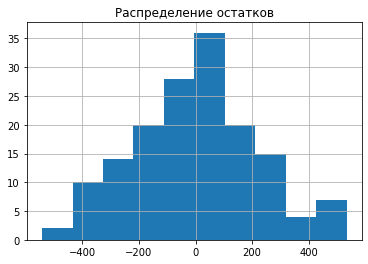

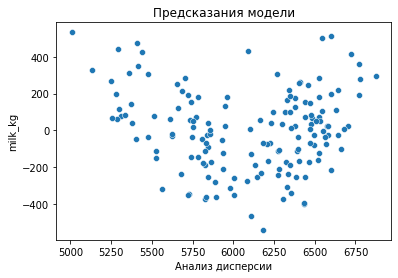

In [69]:
linear_model = LinearRegression()

model = model_test(X_train_for_learning, y_train,
                   X_test_for_learning, y_test,
                  linear_model)

```python
# Расчёт остатков
residuals = y_test-predictions

sns.scatter(y=residuals,x=predictions)
plt.set_xlabel('Предсказания модели')
plt.set_ylabel('Остатки')
plt.set_title('Анализ дисперсии')
plt.show()
```

R2 ближе к единице, чем к минус бесконечности - это говорит и неплохом качестве модели. Остатки распределены неравномерно. Наблюдается линейная зависимость с убывающей дисперсией.

### Обогащение данных

#### Исключение зависимостей

Графики показывают, что СПО и Удой связаны нелинейно. Исключим нелинейность: переведём СПО в категориальный признак, выявив и использовав границу нелинейности.

In [70]:
ferma_main_learning.loc[:, 'is_high_spo'] = (ferma_main_learning.loc[:, 'spo'] > 0.92) * 1.0

ferma_main_learning.head()


,id,milk_kg,eke,protein_g,spo,cow_breed,pasture_type,dad_breed,fat_share,protein_share,taste,age,is_high_spo
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0.0
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0.0
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0.0
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0.0
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0.0


ЭКЕ и Удой также связаны нелинейно. Исключим нелинейность: введём новый признак «ЭКЕ в квадрате».

In [71]:
grferma_main_learning.loc[:, 'eke2'] = ferma_main_learning.loc[:, 'eke'] ** 2

ferma_main_learning.head()

,id,milk_kg,eke,protein_g,spo,cow_breed,pasture_type,dad_breed,fat_share,protein_share,taste,age,is_high_spo,eke2
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0.0,201.64
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0.0,163.84
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0.0,196.00
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0.0,153.76
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0.0,163.84


##### Разбивка на выборки, стандартизация количественных переменных и преобразование категориальных

In [72]:
X = ferma_main_learning.drop(['milk_kg', 'id', 'taste',
                            'protein_share', 'fat_share',
                            'eke', 'spo'], axis=1)
y = ferma_main_learning['milk_kg']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=RANDOM_STATE) 

print(f'''X_train nrows: {X_train.shape[0]} ({round(X_train.shape[0] / X.shape[0] * 100)}%)
X_test nrows:  {X_test.shape[0]} ({round(X_test.shape[0] / X.shape[0] * 100)}%)''')

X_train nrows: 467 (75%)
X_test nrows:  156 (25%)


In [73]:
num_cols = ['eke2', 'protein_g']
cat_cols = ['is_sovering_breed', 'is_sovering_dad',
            'is_hill_pasture', 'is_younger_2_years',
            'is_high_spo']

# Кодируем категориальные переменные и переименовываем колонки
# Кроме is_high_spo, она уже закодирована

enc = OneHotEncoder(drop='first')

cat_X_train = enc.fit_transform(X_train[['cow_breed', 
                                         'dad_breed', 
                                         'pasture_type', 
                                         'age']]).toarray()

cat_X_test = enc.transform(X_test[['cow_breed', 
                                   'dad_breed', 
                                   'pasture_type', 
                                   'age']]).toarray()

In [74]:
cat_X_train_df = pd.DataFrame(cat_X_train, columns=['is_sovering_breed', 
                                                    'is_sovering_dad',
                                                    'is_hill_pasture',
                                                    'is_younger_2_years'])

cat_X_test_df = pd.DataFrame(cat_X_test, columns=['is_sovering_breed', 
                                                  'is_sovering_dad',
                                                  'is_hill_pasture',
                                                  'is_younger_2_years'])

# Соединяем закодированные колонки с общим датасетом
X_train = X_train.reset_index().drop(['index'], axis=1)
X_train_for_learning = X_train.merge(cat_X_train_df, 
                                     left_index=True, 
                                     right_index=True)


X_test = X_test.reset_index().drop(['index'], axis=1)
X_test_for_learning = X_test.merge(cat_X_test_df, 
                                     left_index=True, 
                                     right_index=True)

In [75]:
#Стандартизация

scaler = StandardScaler()

X_train_for_learning_num = scaler.fit_transform(X_train_for_learning[num_cols])
X_train_for_learning_num = pd.DataFrame(X_train_for_learning_num, 
                                        columns=num_cols, 
                                        index=X_train_for_learning.index)

X_test_for_learning_num = scaler.transform(X_test_for_learning[num_cols])
X_test_for_learning_num = pd.DataFrame(X_test_for_learning_num, 
                                       columns=num_cols, 
                                       index=X_test_for_learning.index)

X_train_for_learning =\
    X_train_for_learning_num.merge(X_train_for_learning[cat_cols], how='left', 
                                   left_index=True, right_index=True)

X_test_for_learning =\
    X_test_for_learning_num.merge(X_test_for_learning[cat_cols], how='left', 
                                   left_index=True, right_index=True)

display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,eke2,protein_g,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_high_spo
0,1.626057,0.206082,0.0,1.0,0.0,0.0,1.0
1,1.449208,-0.185338,0.0,0.0,0.0,0.0,1.0
2,-0.430475,0.265882,0.0,0.0,0.0,0.0,0.0
3,-0.946283,-0.832267,1.0,0.0,0.0,0.0,0.0
4,0.032546,-1.397651,0.0,0.0,0.0,0.0,0.0


Train (467, 7)


,eke2,protein_g,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_high_spo
0,-0.728438,0.091918,1.0,1.0,1.0,0.0,0.0
1,-1.963160,-1.446578,0.0,1.0,0.0,1.0,0.0
2,1.537365,0.836702,0.0,0.0,1.0,0.0,1.0
3,-0.580528,-1.066031,0.0,1.0,1.0,0.0,0.0
4,0.931525,-1.158450,0.0,1.0,1.0,0.0,1.0


Test (156, 7)


#### Тест модели на новых выборках

R^2 Score: 0.8347436421181886
RMSE = 190.2826582123474
Confidence Interval (95.0%): (5239.636593089706, 6932.243101111155)


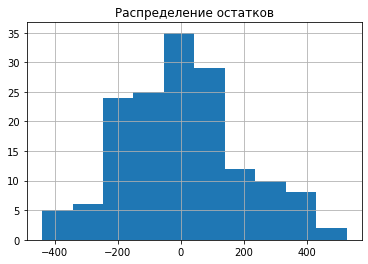

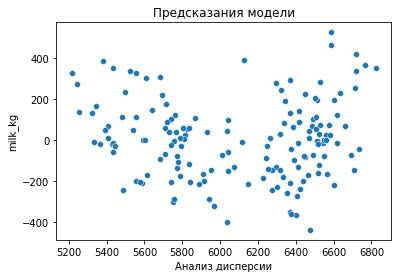

In [76]:
model = model_test(X_train_for_learning, y_train,
                   X_test_for_learning, y_test,
                   linear_model)

R2 удалось увеличить до 0.83. Качество модели улучшилось.

#### Обогащение данных именем папы

Данные можно обогатить признаком "Имя папы". Попробуем.

In [77]:
ferma_main_learning = ferma_main_learning.merge(ferma_dad)

ferma_main_learning.head()

,id,milk_kg,eke,protein_g,spo,cow_breed,pasture_type,dad_breed,fat_share,protein_share,taste,age,is_high_spo,eke2,dad_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0.0,201.64,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0.0,163.84,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0.0,196.00,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0.0,153.76,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0.0,163.84,Барин


In [78]:
X = ferma_main_learning.drop(['milk_kg', 'id', 'taste',
                            'protein_share', 'fat_share',
                            'eke', 'spo'], axis=1)
y = ferma_main_learning['milk_kg']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=RANDOM_STATE) 

print(f'''X_train nrows: {X_train.shape[0]} ({round(X_train.shape[0] / X.shape[0] * 100)}%)
X_test nrows:  {X_test.shape[0]} ({round(X_test.shape[0] / X.shape[0] * 100)}%)''')

num_cols = ['eke2', 'protein_g']
cat_cols = ['is_sovering_breed', 'is_sovering_dad',
            'is_hill_pasture', 'is_younger_2_years',
            'is_high_spo', 'dad_name']

# Кодируем категориальные переменные и переименовываем колонки
# Кроме is_high_spo, она уже закодирована

enc = OneHotEncoder(drop='first')

cat_X_train = enc.fit_transform(X_train[['cow_breed', 
                                         'dad_breed', 
                                         'pasture_type', 
                                         'age', 
                                         'dad_name']]).toarray()

cat_X_test = enc.transform(X_test[['cow_breed', 
                                   'dad_breed', 
                                   'pasture_type', 
                                   'age',
                                   'dad_name']]).toarray()

enc.get_feature_names()

X_train nrows: 467 (75%)
X_test nrows:  156 (25%)


array(['x0_РефлешнСоверинг', 'x1_Соверин', 'x2_холмистое',
       'x3_менее_2_лет', 'x4_Буйный', 'x4_Геркулес', 'x4_Соловчик'],
      dtype=object)

In [79]:
# Переименовываем столбцы
cat_X_train_df = pd.DataFrame(cat_X_train, columns=['is_sovering_breed', 
                                                    'is_sovering_dad',
                                                    'is_hill_pasture',
                                                    'is_younger_2_years',
                                                    'is_furious',
                                                    'is_hercules',
                                                    'is_nightingale'])

cat_X_test_df = pd.DataFrame(cat_X_test, columns=['is_sovering_breed', 
                                                  'is_sovering_dad',
                                                  'is_hill_pasture',
                                                  'is_younger_2_years',
                                                  'is_furious',
                                                  'is_hercules',
                                                  'is_nightingale'])

In [80]:
# Соединяем закодированные колонки с общим датасетом
X_train = X_train.reset_index().drop(['index'], axis=1)
X_train_for_learning = X_train.merge(cat_X_train_df, 
                                     left_index=True, 
                                     right_index=True)

X_test = X_test.reset_index().drop(['index'], axis=1)
X_test_for_learning = X_test.merge(cat_X_test_df, 
                                     left_index=True, 
                                     right_index=True)

display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,protein_g,cow_breed,pasture_type,dad_breed,age,is_high_spo,eke2,dad_name,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1966,Вис Бик Айдиал,равнинное,Соверин,более_2_лет,1.0,275.56,Барин,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1894,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,1.0,268.96,Буйный,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1977,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,0.0,198.81,Буйный,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1775,РефлешнСоверинг,равнинное,Айдиал,более_2_лет,0.0,179.56,Геркулес,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1671,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,0.0,216.09,Буйный,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Train (467, 15)


,protein_g,cow_breed,pasture_type,dad_breed,age,is_high_spo,eke2,dad_name,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1945,РефлешнСоверинг,холмистое,Соверин,более_2_лет,0.0,187.69,Барин,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1662,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,0.0,141.61,Барин,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2082,Вис Бик Айдиал,холмистое,Айдиал,более_2_лет,1.0,272.25,Геркулес,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1732,Вис Бик Айдиал,холмистое,Соверин,более_2_лет,0.0,193.21,Барин,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1715,Вис Бик Айдиал,холмистое,Соверин,более_2_лет,1.0,249.64,Барин,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Test (156, 15)


In [81]:
# Избавляемся от лишних колонок
X_train_for_learning = X_train_for_learning.drop(['cow_breed', 'dad_breed', 
                                                  'pasture_type', 'age',
                                                  'dad_name'], 
                                                  axis=1)

X_test_for_learning = X_test_for_learning.drop(['cow_breed', 'dad_breed', 
                                                'pasture_type', 'age',
                                                'dad_name'], 
                                                axis=1)
display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,protein_g,is_high_spo,eke2,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1966,1.0,275.56,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1894,1.0,268.96,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1977,0.0,198.81,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1775,0.0,179.56,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1671,0.0,216.09,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Train (467, 10)


,protein_g,is_high_spo,eke2,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1945,0.0,187.69,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1662,0.0,141.61,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2082,1.0,272.25,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1732,0.0,193.21,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1715,1.0,249.64,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Test (156, 10)


In [82]:
num_cols = ['eke2', 'protein_g']
cat_cols = ['is_sovering_breed', 'is_sovering_dad',
            'is_hill_pasture', 'is_younger_2_years',
            'is_high_spo', 'is_furious', 'is_hercules',
            'is_nightingale']

In [83]:
scaler = StandardScaler()

X_train_for_learning_num = scaler.fit_transform(X_train_for_learning[num_cols])
X_train_for_learning_num = pd.DataFrame(X_train_for_learning_num, 
                                        columns=num_cols, 
                                        index=X_train_for_learning.index)

X_test_for_learning_num = scaler.transform(X_test_for_learning[num_cols])
X_test_for_learning_num = pd.DataFrame(X_test_for_learning_num, 
                                       columns=num_cols, 
                                       index=X_test_for_learning.index)

X_train_for_learning =\
    X_train_for_learning_num.merge(X_train_for_learning[cat_cols], how='left', 
                                   left_index=True, right_index=True)

X_test_for_learning =\
    X_test_for_learning_num.merge(X_test_for_learning[cat_cols], how='left', 
                                   left_index=True, right_index=True)

display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,eke2,protein_g,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_high_spo,is_furious,is_hercules,is_nightingale
0,1.626057,0.206082,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.449208,-0.185338,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,-0.430475,0.265882,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.946283,-0.832267,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.032546,-1.397651,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Train (467, 10)


,eke2,protein_g,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_high_spo,is_furious,is_hercules,is_nightingale
0,-0.728438,0.091918,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.963160,-1.446578,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.537365,0.836702,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,-0.580528,-1.066031,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.931525,-1.158450,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


Test (156, 10)


R^2 Score: 0.8413986635664519
RMSE = 186.41186117058794
Confidence Interval (95.0%): (5213.555575522231, 6931.8363050584385)


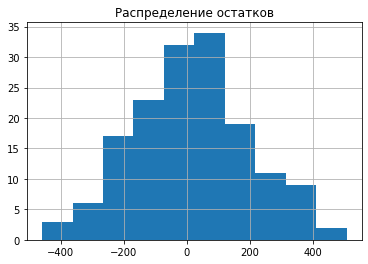

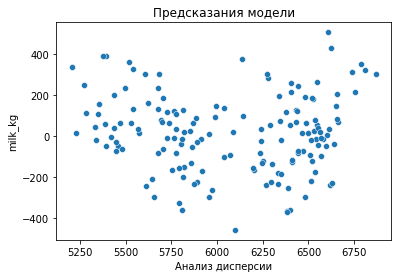

In [84]:
model = model_test(X_train_for_learning, y_train,
                   X_test_for_learning, y_test,
                   linear_model)

Добавив имена отцов, удалось ещё немного улучшить модель.

### Прогнозы удоев для новых коров

#### Подготовка новых данных

In [85]:
display(cow_buy.head())
print(f'''New: {cow_buy.shape}''')

,cow_breed,pasture_type,dad_breed,dad_name,fat_share,protein_share,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


New: (16, 7)


Добавим планируемые показатели корма

In [86]:
cow_buy['eke2'] = (ferma_main_learning['eke'].median() * 1.05) ** 2
cow_buy['protein_g'] = ferma_main_learning['protein_g'].median() * 1.05
cow_buy['is_high_spo'] = ((ferma_main_learning['spo'].median() * 1.05) > 0.92) * 1.0

# отложим обогащенные данные, пригодятся для логистической регрессии
cow_log = cow_buy.copy()

display(cow_buy.head())
print(f'''New: {cow_buy.shape}''')

,cow_breed,pasture_type,dad_breed,dad_name,fat_share,protein_share,age,eke2,protein_g,is_high_spo
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,238.239225,1982.4,1.0
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,238.239225,1982.4,1.0
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,238.239225,1982.4,1.0
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,238.239225,1982.4,1.0
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,238.239225,1982.4,1.0


New: (16, 10)


In [87]:
# Кодируем категориальные
cow_cat = enc.transform(cow_buy[['cow_breed', 'dad_breed', 
                             'pasture_type', 'age',
                             'dad_name']]).toarray()

enc.get_feature_names()

array(['x0_РефлешнСоверинг', 'x1_Соверин', 'x2_холмистое',
       'x3_менее_2_лет', 'x4_Буйный', 'x4_Геркулес', 'x4_Соловчик'],
      dtype=object)

In [88]:
cow_cat_df = pd.DataFrame(cow_cat, columns=['is_sovering_bread', 
                                            'is_sovering_dad',
                                            'is_hill_pasture', 
                                            'is_younger_2_years',
                                            'is_furious', 
                                            'is_hercules', 
                                            'is_nightingale'])

cow_cat_df.head()

,is_sovering_bread,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [89]:
# Стандартизируем количественные данные
cow_num = scaler.transform(cow_buy[['eke2', 'protein_g']])


cow_buy.loc[:, ['eke2', 'protein_g']] = pd.DataFrame(cow_num, columns=['eke2', 'protein_g'])

display(cow_buy.head())
print(f'''New: {cow_buy.shape}''')

,cow_breed,pasture_type,dad_breed,dad_name,fat_share,protein_share,age,eke2,protein_g,is_high_spo
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.626039,0.295239,1.0
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,0.626039,0.295239,1.0
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,0.626039,0.295239,1.0
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.626039,0.295239,1.0
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,0.626039,0.295239,1.0


New: (16, 10)


In [90]:
# Соединяем данные

cow_final = cow_buy.merge(cow_cat_df, left_index=True, right_index=True)

In [91]:
cow_final = cow_final.drop(['cow_breed', 
                            'pasture_type', 
                            'dad_breed', 
                            'dad_name',
                            'fat_share',
                            'protein_share',
                            'age'], axis=1)



display(cow_final.head())
print(f'''New: {cow_final.shape}''')

,eke2,protein_g,is_high_spo,is_sovering_bread,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,0.626039,0.295239,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.626039,0.295239,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.626039,0.295239,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.626039,0.295239,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.626039,0.295239,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


New: (16, 10)


In [92]:
# Предсказываем
predict = model.predict(cow_final)

In [93]:
cow_predict = cow_buy.copy()

In [94]:
cow_predict['milk_predict'] = predict

##### Список коров, которых можно купить, согласно прогнозу

In [95]:
cow_predict[cow_predict['milk_predict'] >= 6000]

,cow_breed,pasture_type,dad_breed,dad_name,fat_share,protein_share,age,eke2,protein_g,is_high_spo,milk_predict
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.626039,0.295239,1.0,6040.460911
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,0.626039,0.295239,1.0,6609.662959
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.626039,0.295239,1.0,6042.298904
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,0.626039,0.295239,1.0,6240.793382
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,0.626039,0.295239,1.0,6706.037762
6,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,0.626039,0.295239,1.0,6246.181499
7,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,0.626039,0.295239,1.0,6405.780363
9,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,0.626039,0.295239,1.0,6342.556303
10,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.68,3.046,более_2_лет,0.626039,0.295239,1.0,6040.460911
11,Вис Бик Айдиал,холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,0.626039,0.295239,1.0,6101.035371


##### Промежуточный вывод (линейная регрессия)

Нам удалось построить алгоритм обработки и подготовки данных для модели, обучить модель и получить прогнозы для удоев коров с фермы. В дальнейшем эту модель можно будет использовать и для покупки новых коров, обогащая её данными поступивших.  
R2 = 84%

## Обучение модели логистической регрессии

#### Вкус молока

На вкус молока точно не будут влиять идентификаторы коров и удои. Остальные признаки в принципе могут повлиять на вкус.

#### Разбивка на выборки

Закодируем целевой признак бинарно

In [96]:
ferma_main_learning['taste'] = (ferma_main_learning['taste'] == 'вкусно') * 1.0

In [97]:
X = ferma_main_learning.drop(['id', 'milk_kg', 'eke', 'taste', 'spo'], axis=1)
y = ferma_main_learning['taste']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=RANDOM_STATE) 

In [98]:
X_train.head()

,protein_g,cow_breed,pasture_type,dad_breed,fat_share,protein_share,age,is_high_spo,eke2,dad_name
188,1966,Вис Бик Айдиал,равнинное,Соверин,3.73,3.077,более_2_лет,1.0,275.56,Барин
208,1894,Вис Бик Айдиал,равнинное,Айдиал,3.72,3.074,более_2_лет,1.0,268.96,Буйный
137,1977,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.078,более_2_лет,0.0,198.81,Буйный
268,1775,РефлешнСоверинг,равнинное,Айдиал,3.63,3.071,более_2_лет,0.0,179.56,Геркулес
581,1671,Вис Бик Айдиал,равнинное,Айдиал,3.18,3.079,более_2_лет,0.0,216.09,Буйный


In [99]:
num_cols = ['eke2', 'protein_g', 
            'fat_share', 'protein_share']
cat_cols = ['cow_breed', 'dad_breed', 
            'pasture_type', 'age', 
            'dad_name']

# Кодируем категориальные переменные и переименовываем колонки
# Кроме is_high_spo, она уже закодирована

enc = OneHotEncoder(drop='first')

cat_X_train = enc.fit_transform(X_train[cat_cols]).toarray()

cat_X_test = enc.transform(X_test[cat_cols]).toarray()

enc.get_feature_names()

array(['x0_РефлешнСоверинг', 'x1_Соверин', 'x2_холмистое',
       'x3_менее_2_лет', 'x4_Буйный', 'x4_Геркулес', 'x4_Соловчик'],
      dtype=object)

In [100]:
# Переименовываем столбцы
cat_X_train_df = pd.DataFrame(cat_X_train, columns=['is_sovering_breed', 
                                                    'is_sovering_dad',
                                                    'is_hill_pasture',
                                                    'is_younger_2_years',
                                                    'is_furious',
                                                    'is_hercules',
                                                    'is_nightingale'])

cat_X_test_df = pd.DataFrame(cat_X_test, columns=['is_sovering_breed', 
                                                  'is_sovering_dad',
                                                  'is_hill_pasture',
                                                  'is_younger_2_years',
                                                  'is_furious',
                                                  'is_hercules',
                                                  'is_nightingale'])

In [101]:
# Соединяем закодированные колонки с общим датасетом
X_train = X_train.reset_index().drop(['index'], axis=1)
X_train_for_learning = X_train.merge(cat_X_train_df, 
                                     left_index=True, 
                                     right_index=True)

X_test = X_test.reset_index().drop(['index'], axis=1)
X_test_for_learning = X_test.merge(cat_X_test_df, 
                                     left_index=True, 
                                     right_index=True)

display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,protein_g,cow_breed,pasture_type,dad_breed,fat_share,protein_share,age,is_high_spo,eke2,dad_name,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1966,Вис Бик Айдиал,равнинное,Соверин,3.73,3.077,более_2_лет,1.0,275.56,Барин,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1894,Вис Бик Айдиал,равнинное,Айдиал,3.72,3.074,более_2_лет,1.0,268.96,Буйный,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1977,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.078,более_2_лет,0.0,198.81,Буйный,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1775,РефлешнСоверинг,равнинное,Айдиал,3.63,3.071,более_2_лет,0.0,179.56,Геркулес,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1671,Вис Бик Айдиал,равнинное,Айдиал,3.18,3.079,более_2_лет,0.0,216.09,Буйный,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Train (467, 17)


,protein_g,cow_breed,pasture_type,dad_breed,fat_share,protein_share,age,is_high_spo,eke2,dad_name,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1945,РефлешнСоверинг,холмистое,Соверин,3.63,3.078,более_2_лет,0.0,187.69,Барин,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1662,Вис Бик Айдиал,равнинное,Соверин,3.28,3.074,менее_2_лет,0.0,141.61,Барин,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2082,Вис Бик Айдиал,холмистое,Айдиал,3.71,3.075,более_2_лет,1.0,272.25,Геркулес,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1732,Вис Бик Айдиал,холмистое,Соверин,3.64,3.073,более_2_лет,0.0,193.21,Барин,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1715,Вис Бик Айдиал,холмистое,Соверин,3.73,3.078,более_2_лет,1.0,249.64,Барин,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Test (156, 17)


In [102]:
# Избавляемся от лишних колонок
X_train_for_learning = X_train_for_learning.drop(['cow_breed', 'dad_breed', 
                                                  'pasture_type', 'age',
                                                  'dad_name'], 
                                                  axis=1)

X_test_for_learning = X_test_for_learning.drop(['cow_breed', 'dad_breed', 
                                                'pasture_type', 'age',
                                                'dad_name'], 
                                                axis=1)
display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,protein_g,fat_share,protein_share,is_high_spo,eke2,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1966,3.73,3.077,1.0,275.56,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1894,3.72,3.074,1.0,268.96,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1977,3.58,3.078,0.0,198.81,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1775,3.63,3.071,0.0,179.56,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1671,3.18,3.079,0.0,216.09,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Train (467, 12)


,protein_g,fat_share,protein_share,is_high_spo,eke2,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1945,3.63,3.078,0.0,187.69,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1662,3.28,3.074,0.0,141.61,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2082,3.71,3.075,1.0,272.25,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1732,3.64,3.073,0.0,193.21,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1715,3.73,3.078,1.0,249.64,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Test (156, 12)


In [103]:
#Стандартизация

scaler = StandardScaler()

X_train_for_learning_num = scaler.fit_transform(X_train_for_learning[num_cols])
X_train_for_learning_num = pd.DataFrame(X_train_for_learning_num, 
                                        columns=num_cols)

X_test_for_learning_num = scaler.transform(X_test_for_learning[num_cols])
X_test_for_learning_num = pd.DataFrame(X_test_for_learning_num, 
                                       columns=num_cols)

In [104]:
X_train_for_learning[num_cols] = X_train_for_learning_num
X_test_for_learning[num_cols] = X_test_for_learning_num

display(X_train_for_learning.head())
print(f'''Train: {X_train_for_learning.shape}''')

display(X_test_for_learning.head())
print(f'''Test: {X_test_for_learning.shape}''')

,protein_g,fat_share,protein_share,is_high_spo,eke2,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,0.206082,0.727262,0.550740,1.0,1.626057,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.185338,0.665466,-0.656751,1.0,1.449208,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.265882,-0.199680,0.953236,0.0,-0.430475,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.832267,0.109301,-1.864241,0.0,-0.946283,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.397651,-2.671524,1.355733,0.0,0.032546,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Train: (467, 12)


,protein_g,fat_share,protein_share,is_high_spo,eke2,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,0.091918,0.109301,0.953236,0.0,-0.728438,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,-1.446578,-2.053563,-0.656751,0.0,-1.963160,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.836702,0.603670,-0.254254,1.0,1.537365,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-1.066031,0.171097,-1.059247,0.0,-0.580528,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,-1.158450,0.727262,0.953236,1.0,0.931525,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Test: (156, 12)


In [105]:
logistic_model = LogisticRegression(random_state=RANDOM_STATE)

In [106]:
# Обучаем
logistic_model.fit(X_train_for_learning, y_train)

# Предсказываем
y_pred = logistic_model.predict(X_test_for_learning)

In [107]:
# Считаем метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'''Accuracy: {accuracy}
Precision: {precision}
Recall: {recall}''')

confusion_matrix(y_test, y_pred)

Accuracy: 0.6153846153846154
Precision: 0.6216216216216216
Recall: 0.7931034482758621


array([[27, 42],
       [18, 69]])

In [108]:
y_proba = logistic_model.predict_proba(X_test_for_learning)

In [109]:
data = pd.DataFrame({'y_valid': y_test.to_numpy(), 'y_pred': y_pred, 'y_proba': y_proba[:, 1]})
data.head()

,y_valid,y_pred,y_proba
0,1.0,1.0,0.716267
1,0.0,0.0,0.287427
2,1.0,1.0,0.816418
3,0.0,1.0,0.675481
4,1.0,1.0,0.766379


In [110]:
# Ищем порог, при котором получаем ложно-положительные срабатывания
data[(data['y_valid'] == 0.0)
     &
     (data['y_pred'] == 1.0)]['y_proba'].max()

0.8087736431349019

Дополним функцию предсказаний.

In [111]:
threshold = 0.809

In [112]:
y_pred_upgraded = (y_proba[:, 1] >= threshold) * 1

In [113]:
precision_score(y_test, y_pred_upgraded)

1.0

#### Подготовка новых данных

In [114]:
cow_log.head()

,cow_breed,pasture_type,dad_breed,dad_name,fat_share,protein_share,age,eke2,protein_g,is_high_spo
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,238.239225,1982.4,1.0
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,238.239225,1982.4,1.0
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,238.239225,1982.4,1.0
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,238.239225,1982.4,1.0
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,238.239225,1982.4,1.0


In [115]:
cow_cat = enc.transform(cow_log[cat_cols]).toarray()

cow_cat_df = pd.DataFrame(cow_cat, columns=['is_sovering_breed', 
                                            'is_sovering_dad',
                                            'is_hill_pasture',
                                            'is_younger_2_years',
                                            'is_furious',
                                            'is_hercules',
                                            'is_nightingale'])

cow_log = cow_log.reset_index().drop(['index'], axis=1)
cow_log = cow_log.merge(cow_cat_df, 
                        left_index=True, 
                        right_index=True)

cow_log = cow_log.drop(['cow_breed', 'dad_breed', 
                        'pasture_type', 'age',
                        'dad_name'], 
                        axis=1)

cow_log.head()

,fat_share,protein_share,eke2,protein_g,is_high_spo,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,3.58,3.076,238.239225,1982.4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,3.54,3.081,238.239225,1982.4,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,3.59,3.074,238.239225,1982.4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3.40,3.061,238.239225,1982.4,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,3.64,3.074,238.239225,1982.4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [116]:
#Стандартизация
cow_num = scaler.transform(cow_log[num_cols])
cow_log[num_cols] = pd.DataFrame(cow_num, 
                                 columns=num_cols)

cow_log.head()

,fat_share,protein_share,eke2,protein_g,is_high_spo,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,-0.199680,0.148243,0.626039,0.295239,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.446864,2.160727,0.626039,0.295239,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,-0.137883,-0.656751,0.626039,0.295239,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-1.312010,-5.889209,0.626039,0.295239,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.171097,-0.656751,0.626039,0.295239,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [117]:
y_proba = logistic_model.predict_proba(cow_log)

In [118]:
y_proba

array([[0.15884929, 0.84115071],
       [0.21409625, 0.78590375],
       [0.25083578, 0.74916422],
       [0.25235051, 0.74764949],
       [0.24350585, 0.75649415],
       [0.43582344, 0.56417656],
       [0.20145992, 0.79854008],
       [0.19727323, 0.80272677],
       [0.2691404 , 0.7308596 ],
       [0.28649588, 0.71350412],
       [0.24569128, 0.75430872],
       [0.16277016, 0.83722984],
       [0.23589205, 0.76410795],
       [0.17736461, 0.82263539],
       [0.39369403, 0.60630597],
       [0.29550129, 0.70449871]])

In [119]:
cow_predict['is_tasty'] = y_proba[:, 1] > 0.809

## Результат

Фермер может купить только двух коров с индексами 0 и 11

In [120]:
cow_predict[(cow_predict['is_tasty'] == True)
            &
            (cow_predict['milk_predict'] >= 6000)]

,cow_breed,pasture_type,dad_breed,dad_name,fat_share,protein_share,age,eke2,protein_g,is_high_spo,milk_predict,is_tasty
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.626039,0.295239,1.0,6040.460911,True
11,Вис Бик Айдиал,холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,0.626039,0.295239,1.0,6101.035371,True


## Итоговые выводы

- Удалили явные и неявные дубликаты;
- Визуально оценили распределение переменных;
- Обогатили набор данных для обучения;
- Выявили нелинейные зависимости некоторых переменных;
- Ввели новые фичи, которые помогли улучшить модели;
- Предказали удои с помощью модели линейной регрессии;
- Предсказали вкус молока с помощью модели логистической регрессии;
- Выяснили, каких коров стоит купить нашему заказчику.

#### В ходе корреляционного анализа выявили что:

Больше всего с целевой переменной коррелируют характеристики корма: ЭКЕ, количество граммов чистого протеина и СПО.

#### Задача регрессии

- В первом случае мы получили R2 - 0.78, это говорит нам о неплохом качестве модели. Остатки распределены неравномерно. Наблюдается линейная зависимость с убывающей дисперсией. 
- Мы увидели что СПО и Удой связаны нелинейно. И исключили нелинейность. после чего ввели новый признак «ЭКЕ в квадрате». R2 удалось увеличить до 0.83. Качество модели улучшилось.  
- Далее мы обогатили данные признаком "Имя папы" и улучшили качество модели удалось ещё немного R2 - 0.84.
- Нам удалось построить алгоритм обработки и подготовки данных для модели, обучить модель и получить прогнозы для удоев коров с фермы. В дальнейшем эту модель можно будет использовать и для покупки новых коров, обогащая её данными поступивших.

#### Задача классификации

Метрики тестовой выборки показывают следующее качество:
- Accuracy: 0.61
- Precision: 0.62
- Recall: 0.79 

Порог, при котором получаем ложно-положительные срабатывания:
- 0.80

- На удои больше всего влияют показатели корма: 
- ЭКЕ, СПО и содержание белка;
- На вкус молока - показатели самого молока: 
- содержание белка и жирность;
- С нашими моделями заказчик сможет рассмотреть нескольких фермеров и собрать себе идеальное стадо.

## Результат

Фермер может купить только двух коров с индексами 0 и 11